## Erdos Insitute Data Science Bootcamp Spring 2023
## Final Project: SPY ETF Short-term Price Prediction
### Team: Algebros (Members: Sailun Zhan, Xinwu Yang, Aolong Li, Amin Idelhaj, Zongze Liu)
### Author for this notebook: Xinwu Yang, Sailun Zhan, Aolong Li

In [253]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
# from datetime import datetime, timedelta, time
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [254]:
### We first import the 1-min interval open/high/low price data from 4/3/2023 to 6/1/2023. 
### All the data is available at AlphaVantage. 

df_min_month1 = pd.read_csv('./data/extended_intraday_SPY_1min_year1month1_adjusted.csv', parse_dates=['time'])
df_min_month2 = pd.read_csv('./data/extended_intraday_SPY_1min_year1month2_adjusted.csv', parse_dates=['time'])

df_min = pd.merge(df_min_month1, df_min_month2, how = 'outer')


### We are only interested in the data during regular trading hours, 
### so we exclude the data before 9:30 and after 16:00 every day.

start_time = pd.to_datetime('9:30').time()
end_time = pd.to_datetime('16:00').time()

df_min = df_min[(df_min['time'].dt.time >= start_time) & (df_min['time'].dt.time <= end_time)]

df_min.shape

(16422, 6)

In [255]:
### Transform the data into numpy array to prepare for our model

data_array = df_min[['open', 'high', 'low']].to_numpy()

data_array.shape

(16422, 3)

In [256]:
### Train and test splits
### Avoid 9:30 to 11:30 period, since our program uses previous 120 minutes information to do training
### In 9:30 to 11:30 period, the previous day info will be used


def split(df, n):
    np.random.seed(42)
    random_index = np.random.choice(range(60, df_min.shape[0]), size=n, replace=False)
    while (df.iloc[random_index]['time'].dt.time < pd.to_datetime('11:30').time()).any() :
        random_index = np.random.choice(range(60, df_min.shape[0]), size=n, replace=False)
    return np.sort(random_index)[::-1]

In [257]:
test_idx = split(df_min, 4)
time_list = df_min['time'].iloc[random_index]

### Append 60 since we want to test our model on the most recent 60 minutes
test_idx = np.append(test_idx, [60])

test_idx

array([13148,  8446,  3171,   457,    60])

In [258]:
### Model training and testing
### Reference: "Hidden Markov Model for Stock Trading" by Nguyet Nguyen

num_prediction = 60
num_iteration = 10000
K = 120

MAE_opens, MAE_highs, MAE_lows = [], [], []
comparisions = []

for i in range(len(test_idx)):
    test_index = test_idx[i]
    
    whole_dataset = data_array[test_index:, :]
    predicted_price = np.empty([0,whole_dataset.shape[1]])
    

    for idx in reversed(range(num_prediction)):
            train_dataset = whole_dataset[idx + 1:,:]
            num_examples = train_dataset.shape[0]
            
            if idx == num_prediction-1:
                model = hmm.GaussianHMM(n_components=4, covariance_type='diag',  tol=0.0001, n_iter=num_iteration, init_params='stmc')
            else: # fit the model using previous computed transmat_, startprob_, means_, covars_
                model = hmm.GaussianHMM(n_components=4, covariance_type='full', tol=0.0001, n_iter=num_iteration, init_params = '')
                model.transmat_ = transmat_previous
                model.startprob_ = startprob_previous
                model.means_ = means_previous
                model.covars_ = covars_previous
            
            # flipud since the dataset is sorted in time descending order (from recent to past)
            model.fit(np.flipud(train_dataset))
            transmat_previous = model.transmat_
            startprob_previous = model.startprob_
            means_previous = model.means_
            covars_previous = model.covars_
            
            
            # predict the price corresponding to whole_dataset[idx]  
            iters = 1
            previous_probability = []
            current_probability = model.score(np.flipud(train_dataset[0:K, :]))
            while iters < num_examples / K - 1:
                previous_probability = np.append(previous_probability, model.score(np.flipud(train_dataset[iters:iters + K, :])))
                iters = iters + 1
            
            # find the most similar state at time t* to whole_dataset[idx + 1]
            # "most similar" means P( train_dataset[0:K] | parameters) - P( train_dataset[t*:t*+K]| parameters ) is minimized 
            # over all possible t* in the past two hours
            diff_idx = np.argmin(np.absolute(previous_probability - current_probability))
            
            # the change y(t+1) - y(t) = y(t*+1) - y(t*)
            predicted_change = train_dataset[diff_idx,:] - train_dataset[diff_idx + 1,:]
            predicted_price = np.vstack((predicted_price, whole_dataset[idx + 1,:] + predicted_change))
    
    ### Storing the predictions and corresponding true values
    comparisions += [ (np.flipud(whole_dataset[range(num_prediction), 1:3]), predicted_price[:, 1:3]) ]
                    

    ### Computing the MAE

    MAE_open = mean_absolute_error(np.flipud(whole_dataset[range(num_prediction),0]), predicted_price[:,0])
    MAE_high = mean_absolute_error(np.flipud(whole_dataset[range(num_prediction),1]), predicted_price[:,1])
    MAE_low = mean_absolute_error(np.flipud(whole_dataset[range(num_prediction),2]), predicted_price[:,2])
    
    MAE_opens += [MAE_open]
    MAE_highs += [MAE_high]
    MAE_lows += [MAE_low]
    

In [259]:
### NOTE: the MAE results might be different from those in the presentation video and slides 
### because of the train-test split

print(MAE_opens[-1])
print(MAE_highs[-1])
print(MAE_lows[-1])

print(np.mean(np.array(MAE_opens)), np.mean(np.array(MAE_highs)), np.mean(np.array(MAE_lows)))

0.0986866666666676
0.07789833333333339
0.075726666666669
0.13670066666666628 0.11528499999999761 0.11129766666666967


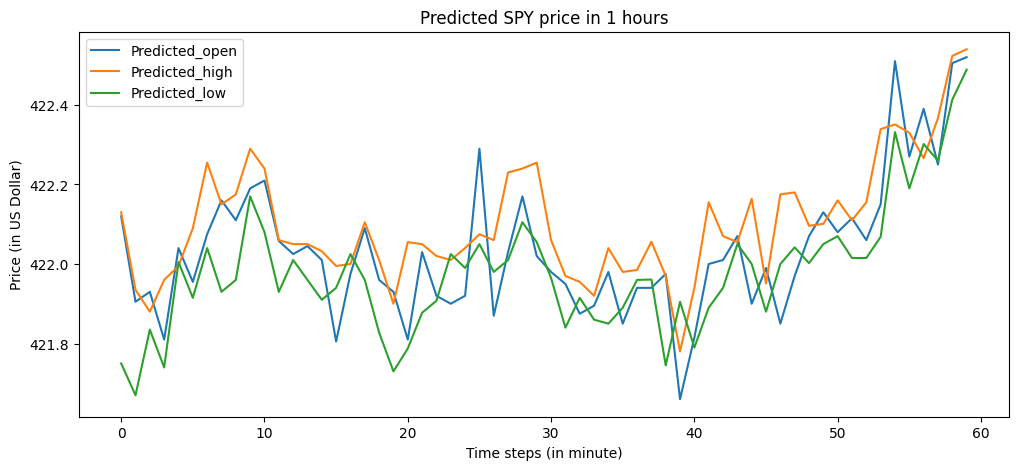

In [260]:
### Plot the predicted price
### Observe some potential problem here: low > high/open or high < low/open for some predictions
### NOTE: the graph might be different from that in the presentation video and slides because of the train-test split

plt.figure(figsize=(12,5))
pred_open = plt.plot(range(num_prediction), predicted_price[:,0])
pred_high = plt.plot(range(num_prediction), predicted_price[:,1])
pred_low = plt.plot(range(num_prediction), predicted_price[:,2])
plt.title('Predicted SPY price in 1 hours')
plt.legend(('Predicted_open', 'Predicted_high', 'Predicted_low'))
plt.xlabel('Time steps (in minute)')
plt.ylabel('Price (in US Dollar)')

plt.show()

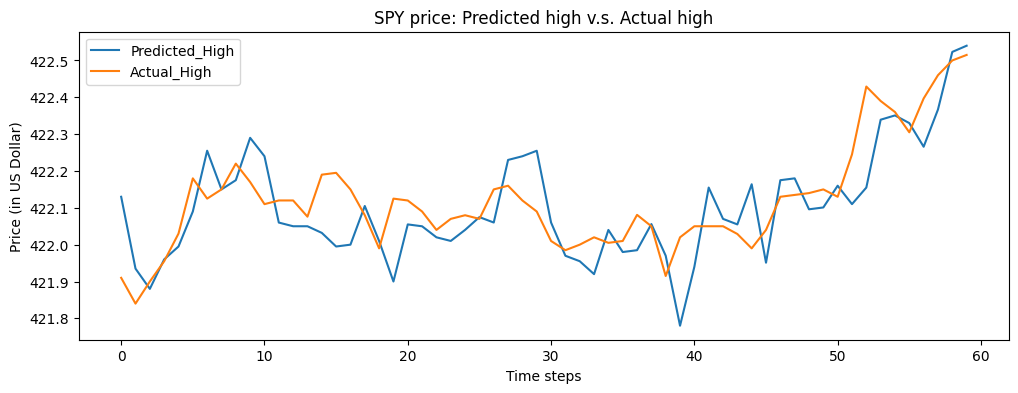

In [261]:
### Plot high price comparison
### NOTE: the graph might be different from that in the presentation video and slides because of the train-test split

plt.figure(figsize=(12,4))
pred = plt.plot(range(num_prediction), predicted_price[:, 1])
actual = plt.plot(range(num_prediction),np.flipud(whole_dataset[range(num_prediction),1]))
plt.title('SPY price: Predicted high v.s. Actual high')
plt.legend(('Predicted_High', 'Actual_High'))
plt.xlabel('Time steps')
plt.ylabel('Price (in US Dollar)')

plt.show()

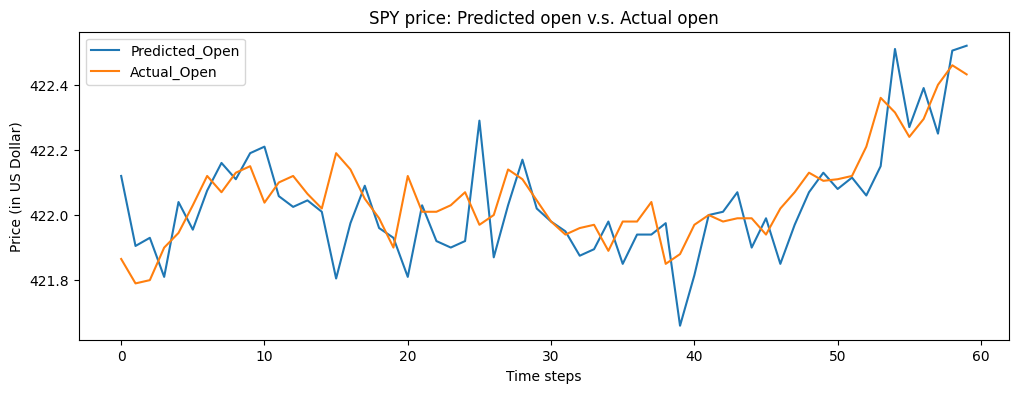

In [262]:
### Plot open price comparison
### NOTE: the graph might be different from that in the presentation video and slides because of the train-test split

plt.figure(figsize=(12,4))
pred = plt.plot(range(num_prediction), predicted_price[:, 0])
actual = plt.plot(range(num_prediction),np.flipud(whole_dataset[range(num_prediction),0]))
plt.title('SPY price: Predicted open v.s. Actual open')
plt.legend(('Predicted_Open', 'Actual_Open'))
plt.xlabel('Time steps')
plt.ylabel('Price (in US Dollar)')

plt.show()

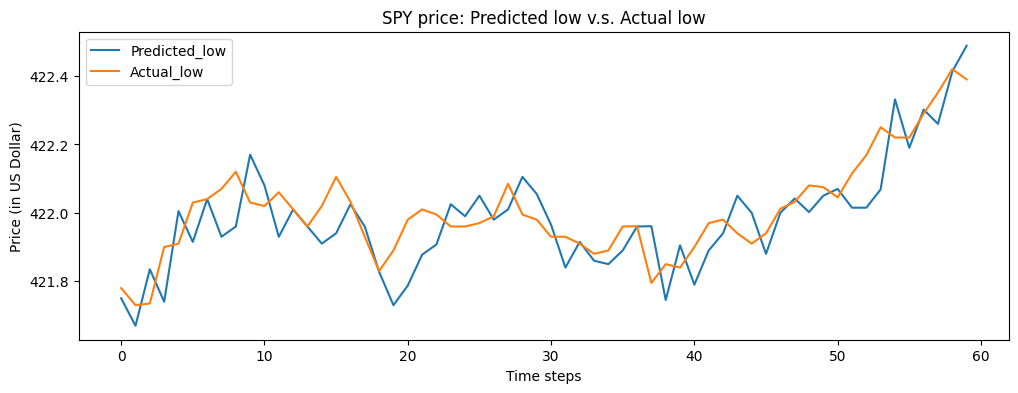

In [263]:
### Plot low price comparisons
### NOTE: the graph might be different from the presentation video and slides because of the train-test split

plt.figure(figsize=(12,4))
pred = plt.plot(range(num_prediction), predicted_price[:, 2])
actual = plt.plot(range(num_prediction),np.flipud(whole_dataset[range(num_prediction),2]))
plt.title('SPY price: Predicted low v.s. Actual low')
plt.legend(('Predicted_low', 'Actual_low'))
plt.xlabel('Time steps')
plt.ylabel('Price (in US Dollar)')

plt.show()